# Implementation of Neural Collaborative Filtering

## Environment Setup

### Create Virtual Environment

```bash
conda create -n ncf python=3.10
conda activate ncf
```

### Install Required Libraries

Install required libraries by running the following command
(for torch installation, you can refer to [official website](https://pytorch.org/get-started/locally/) for detailed instructions based on your environment to avoid compatibility issues):

In [1]:
%pip install torch torchvision torchaudio
%pip install pandas
%pip install matplotlib

  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.

In [6]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset

## load data

In real-world scenarios, three datasets are commonly used in the creation of the model: training, validation, and testing. The model is initially trained on the training dataset, and the validation dataset provides an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The testing dataset is used to evaluate the model after the model has been trained and tuned.

Note: 
1. test data is not observed during the training process, and the model is not tuned based on the test data.
2. do not look at the test data until the model is finalized and ready for evaluation.

In this tutorial, for simplicity, we will use the validation dataset for testing. 

In [7]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/valid.csv')

## Data Preprocessing

We will create a mapping from the user and item IDs to a unique index. Since there are missing user and item IDs (i.e., not all user IDs and item IDs in the test data are present in the training data), we map those missing IDs to a special index (0). 

In [8]:
def create_mapping(df):
    """
    Create a mapping from the unique values of the columns to integers, leaving 0 for missing values.
    """
    user_ids = df['user_id'].unique()
    item_ids = df['business_id'].unique()

    user_id_map = {user_id: i + 1 for i, user_id in enumerate(user_ids)}
    item_id_map = {item_id: i + 1 for i, item_id in enumerate(item_ids)}
    return user_id_map, item_id_map

In [9]:
user_map, item_map = create_mapping(df_train)
df_train['user_id'] = df_train['user_id'].map(user_map).fillna(0).astype(int)
df_train['business_id'] = df_train['business_id'].map(item_map).fillna(0).astype(int)

df_test['user_id'] = df_test['user_id'].map(user_map).fillna(0).astype(int)
df_test['business_id'] = df_test['business_id'].map(item_map).fillna(0).astype(int)

In [10]:
df_train.head()

,user_id,business_id,stars
0,1,1,1.0
1,2,2,5.0
2,3,3,5.0
3,4,4,5.0
4,5,5,4.0


# Implementation of Neural Collaborative Filtering in PyTorch

## Dataset and DataLoader

To load the data from dataset, you should implement a custom dataset class that inherits from the `torch.utils.data.Dataset` class. The custom dataset class should implement the `__len__` and `__getitem__` methods.

In [11]:
class RatingDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(df['business_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['stars'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

## Model

Components of the model:

1. Input layer: User and item embeddings
2. Interaction layer: Concatenation of user and item embeddings
3. Neural network: Fully connected layers with ReLU activation functions
4. Output layer: Rating prediction

In [12]:
class NeuralCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=50, hidden_dim=64):
        super().__init__()
        self.user_embed = nn.Embedding(num_users+1, embedding_dim, padding_idx=0)
        self.item_embed = nn.Embedding(num_items+1, embedding_dim, padding_idx=0)
        self.fc_layers = nn.Sequential(
            nn.Linear(2*embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )
        
    def forward(self, user, item):
        user_vec = self.user_embed(user)
        item_vec = self.item_embed(item)
        concat = torch.cat([user_vec, item_vec], dim=-1)
        return self.fc_layers(concat).squeeze()

## Training

The training process involves the following steps:

1. Forward pass: Compute the predicted ratings
2. Compute the loss: Compute the loss between the predicted ratings and the true ratings
3. Backward pass: Compute the gradients of the loss with respect to the model parameters
4. Update the model parameters: Update the model parameters using the gradients
5. Repeat the process for multiple epochs

We will use the Mean Squared Error (MSE) loss function and the Adam optimizer.

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

In [13]:
num_users = len(user_map)
num_items = len(item_map)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")
model = NeuralCF(num_users, num_items)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = RatingDataset(df_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = RatingDataset(df_test)
test_loader = DataLoader(test_dataset, batch_size=32)
losses = []

for epoch in range(3):
    model.train()
    epoch_loss = 0
    for user, item, rating in train_loader:
        user, item, rating = user.to(device), item.to(device), rating.to(device)
        optimizer.zero_grad()
        pred = model(user, item)
        loss = criterion(pred, rating)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Using cpu
Epoch 1, Loss: 1.5475
Epoch 2, Loss: 1.2386
Epoch 3, Loss: 1.1066


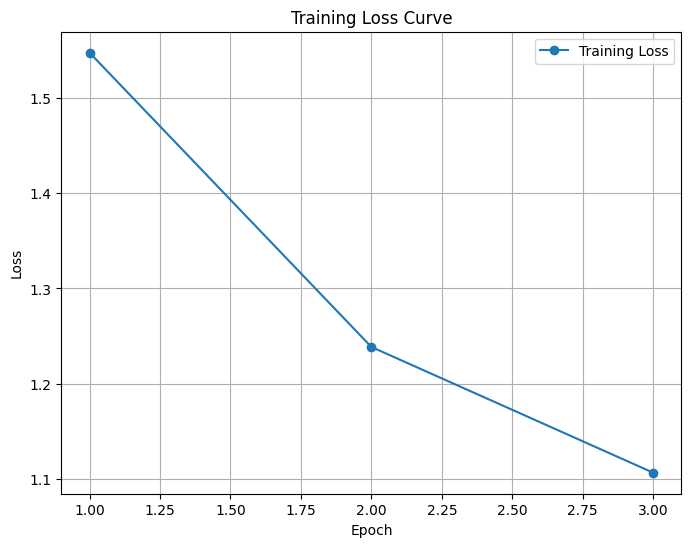

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

We will evaluate the model using the Root Mean Squared Error (RMSE) metric.

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

In [15]:
def compute_rmse(model, loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for user, item, rating in loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            pred = model(user, item)
            total_loss += nn.MSELoss(reduction='sum')(pred, rating).item()
    mse = total_loss / len(loader.dataset)
    return torch.sqrt(torch.tensor(mse)).item()

train_rmse = compute_rmse(model, train_loader)
test_rmse = compute_rmse(model, test_loader)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 0.9926
Test RMSE: 1.1513
